### Does not work for the latest version..

In [1]:
# load modules
import numpy as np
import curvedsky
import basic
import cmb
from matplotlib.pyplot import *

In [2]:
# define parameters
Tcmb  = 2.726e6    # CMB temperature
lmax  = 3000       # maximum multipole of output normalization
rlmin = 100
rlmax = 3000      # reconstruction multipole range
sig   = 10.
ac2rad = np.pi/180./60.
L = np.linspace(0,lmax,lmax+1)

In [3]:
# load unlensed and lensed Cls
lcl = cmb.read_camb_cls('../data/lensedcls.dat',ftype='lens',output='array')[:,:lmax+1]
nl  = np.zeros((4,lmax+1))
nl[0,:] = (sig*ac2rad/Tcmb)**2
nl[1,:] = 2*nl[0,:]
nl[2,:] = 2*nl[0,:]
ocl = lcl + nl

In [4]:
# calculate normalizations
Al = {}
Rl = {}
Al['qEB'] = curvedsky.norm_quad.qeb('rot',lmax,rlmin,rlmax,lcl[1,:],ocl[1,:],ocl[2,:])
Al['oEB'] = curvedsky.norm_imag.qeb('amp',lmax,rlmin,rlmax,lcl[1,:],ocl[1,:],ocl[2,:])
Rl['qEB'] = curvedsky.norm_quad.xeb('rotamp',lmax,rlmin,rlmax,lcl[1,:],lcl[1,:],ocl[1,:],ocl[2,:])
Il = 1./(1.-Al['qEB']*Al['oEB']*Rl['qEB']**2)
Al['QEB'] = Al['qEB']*Il

In [5]:
# simple diagonal c-inverse
Fl = np.zeros((3,lmax+1,lmax+1))
for l in range(rlmin,rlmax):
    Fl[:,l,0:l+1] = 1./ocl[:3,l,None]

In [6]:
# generate CMB alms 
# - gaussian alms are generated, and the reconstructed cls are equal to the normalization
Talm, Ealm, Balm = curvedsky.utils.gaussTEB(lmax,lcl[0,:],lcl[1,:],lcl[2,:],lcl[3,:])
Talm += curvedsky.utils.gauss1alm(lmax,nl[0,:])
Ealm += curvedsky.utils.gauss1alm(lmax,nl[1,:])
Balm += curvedsky.utils.gauss1alm(lmax,nl[2,:])

In [7]:
# diagonal filtering
Talm *= Fl[0,:,:]
Ealm *= Fl[1,:,:]
Balm *= Fl[2,:,:]

In [8]:
# compute unnormalized estiamtors
alm = {}
alm['qEB'] = curvedsky.rec_rot.qeb(lmax,rlmin,rlmax,lcl[1,:],Ealm,Balm)
alm['oEB'] = curvedsky.rec_iamp.qeb(lmax,rlmin,rlmax,lcl[1,:],Ealm,Balm)

In [9]:
# normalized estimators
for qest in ['qEB','oEB']:
    alm[qest] *= Al[qest][0,:,None]

In [11]:
# bhe
alm['QEB'] = alm['qEB'] - Al['qEB'][0,:,None]*Rl['qEB'][:,None]*alm['oEB']
alm['QEB'] *= Il[0,:,None]

In [12]:
print(Al['qEB']*Al['oEB']*Rl['qEB']**2)

[[0.00000000e+00 5.41329679e-12 2.16486451e-11 ... 8.17620009e-03
  8.18107192e-03 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


In [13]:
# compute power spectrum
cl = {}
for qest in ['qEB','oEB','QEB']:
    cl[qest] = curvedsky.utils.alm2cl(lmax,alm[qest])

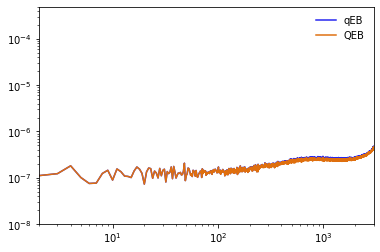

In [16]:
xscale('log')
yscale('log')
xlim(2,lmax)
ylim(1e-8,5e-4)
for qest in ['qEB','QEB']:
    plot(L,cl[qest],label=qest)
legend()